In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Data visualization

In [2]:
file_name = 'CESM_EA_SPI.nc'
ds = xr.open_dataset(file_name)
spi = ds['spi']
spi

<xarray.DataArray 'spi' (time: 21612, lat: 13, lon: 20)>
[5619120 values with dtype=float64]
Coordinates:
  * time     (time) object '0400-01-16T12:00:00' ... '2200-12-16T12:00:00'
  * lat      (lat) float64 3.298 4.241 5.183 6.126 ... 11.78 12.72 13.66 14.61
  * lon      (lon) float64 23.75 25.0 26.25 27.5 28.75 ... 43.75 45.0 46.25 47.5
Attributes:
    title:          Standardized Precipitation Index
    standard_name:  atmosphere_water__standardized_precipitation_wetness_index
    long_name:      Standardized Precipitation Index
    units:          unitless
    valid_min:      -3.09
    valid_max:      3.09
    valid_range:    [-3.09  3.09]

6535


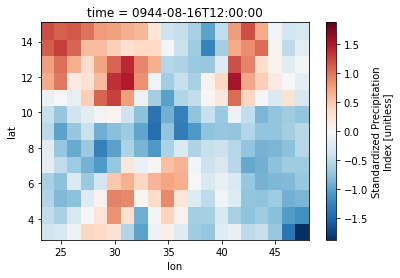

In [3]:
#plot spatial spi distribution for random time
time = np.random.randint(spi.shape[0])
print(time)
spi2d = spi.isel(time=time)
spi2d.plot()

1 4 18777


Text(0, 0.5, 'SPI')

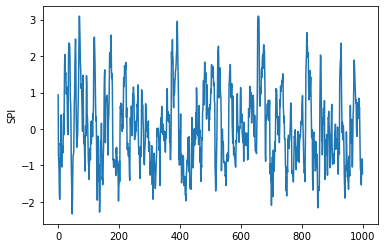

In [4]:
#plot spi time series at random location
lat = np.random.randint(spi.shape[1])
lon = np.random.randint(spi.shape[2])
k = np.random.randint(spi.shape[0]-1000)
print(lat,lon,k)
plt.plot(spi[k:k+1000,lat,lon])
plt.ylabel('SPI')

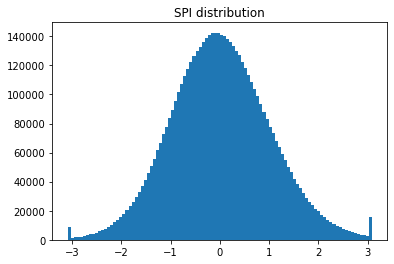

(5619120,)


In [5]:
#plot overall spi distribution
plt.hist(np.array(spi).flatten(), bins=100)
plt.title('SPI distribution')
plt.show()
print(np.shape(np.array(spi).flatten()))

# Prepare data

In [6]:
def assemble_predictors_predictands(start_date, end_date, lead_time, dataset, num_input_time_steps):
    '''
    Args
    ----
    start_date (str): The start date for extraction. Important, put the trailing 0 at the beginning of year for dates before 1000 (e.g., '0400')
    end_date (str): The end date for extraction
    lead_time (int): The number of months between the predictor/predictand
    dataset (str): Either 'CESM' or 'ECMWF'
    num_input_time_steps (int): The number of time steps to use for each predictor samples
    '''    
    file_name = {'CESM': 'CESM_EA_SPI.nc', 'ECMWF': 'ECMWF_EA_SPI.nc'}[dataset]
    ds = xr.open_dataset(file_name)
    spi = ds['spi'].sel(time=slice(start_date,end_date))   # 3D (time,lat,lon)
    num_samples=spi.shape[0]
    #Stack and remove nans
    spi = np.stack([spi.values[n-num_input_time_steps:n] for n in range(num_input_time_steps, num_samples+1)])
    num_samples = spi.shape[0]
    spi[np.isnan(spi)] = 0   # 4D (time,timestep,lat,lon)
    #make sure we have floats in there
    X = spi.astype(np.float32)
    # select Y
    if dataset == 'ECMWF':
        start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    elif dataset == 'CESM':
        t_start=datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
        t_end=datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
        start_date_plus_lead = t_start + relativedelta(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = t_end + relativedelta(months=lead_time)
        if len(str(start_date_plus_lead.year))<4:
            start_date_plus_lead = '0'+start_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(start_date_plus_lead.year))==4:
            start_date_plus_lead = start_date_plus_lead.strftime('%Y-%m-%d')
        if len(str(end_date_plus_lead.year))<4:
            end_date_plus_lead = '0'+end_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(end_date_plus_lead.year))==4:
            end_date_plus_lead = end_date_plus_lead.strftime('%Y-%m-%d')
    subsetted_ds = ds['spi'].sel(time=slice(start_date_plus_lead, end_date_plus_lead))
    y = subsetted_ds.values.astype(np.float32) # 3D (time,lat,lon)
    y[np.isnan(y)] = 0
    ds.close()
    X = np.moveaxis(X, 1,3) # 4D(time,lat,lon,timestep)
    orig_shape_X = X.shape
    orig_shape_y = y.shape
    y = y.reshape(np.shape(y)[0]*np.shape(y)[1]*np.shape(y)[2])
    
    X = X.reshape(np.shape(X)[0]*np.shape(X)[1]*np.shape(X)[2], np.shape(X)[3])
    return X,y, orig_shape_X, orig_shape_y

In [63]:
##Parameters
num_input_time_steps = 3 
lead_time = 3

num_epochs = 100

climate_model = 'CESM'
train_start_date = '1700-01-01'
train_end_date = '1900-12-31'

valid_start_date = '1901-01-01'
valid_end_date = '2060-12-31'

test_start_date = '2061-01-01'
test_end_date = '2100-12-31'

In [64]:
train_predictors, train_predictands, orig_shape_Xtrain, orig_shape_ytrain = assemble_predictors_predictands(train_start_date, train_end_date, lead_time, climate_model, num_input_time_steps)
valid_predictors, valid_predictands, orig_shape_Xvalid, orig_shape_yvalid = assemble_predictors_predictands(valid_start_date, valid_end_date, lead_time, climate_model,num_input_time_steps)
test_predictors, test_predictands, orig_shape_Xtest, orig_shape_ytest = assemble_predictors_predictands(test_start_date, test_end_date, lead_time, climate_model,num_input_time_steps)

In [65]:
print(np.shape(train_predictors),np.shape(train_predictands))
print(np.shape(valid_predictors),np.shape(valid_predictands))
print(np.shape(test_predictors),np.shape(test_predictands))
lat = ds['lat']
lon = ds['lon']
lat = np.array(lat)
lon = np.array(lon)
nlat = len(lat)
nlon = len(lon)
print(nlat,nlon)

(626600, 3) (626600,)
(498680, 3) (498680,)
(124280, 3) (124280,)
13 20


# multiple linear regression baseline

In [66]:
regr = LinearRegression()
regr.fit(train_predictors, train_predictands)

LinearRegression()

In [67]:
pred = regr.predict(test_predictors)
print(np.shape(test_predictands),np.shape(pred))

(124280,) (124280,)


In [68]:
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

MSE: 0.6542812


In [69]:
train_xt = train_predictors.reshape(orig_shape_Xtrain)
train_yt = train_predictands.reshape(orig_shape_ytrain)
valid_xt = valid_predictors.reshape(orig_shape_Xvalid)
test_xt = test_predictors.reshape(orig_shape_Xtest)
print(train_xt.shape,valid_xt.shape,test_xt.shape,train_yt.shape)

(2410, 13, 20, 3) (1918, 13, 20, 3) (478, 13, 20, 3) (2410, 13, 20)


In [70]:
# prepare data for parallel training
train_x = np.ndarray((len(train_xt),nlat,nlon,nlat,nlon,3))
valid_x = np.ndarray((len(valid_xt),nlat,nlon,nlat,nlon,3))
test_x = np.ndarray((len(test_xt),nlat,nlon,nlat,nlon,3))
for ii in range(nlat):
    for jj in range(nlon):
        train_x[:,ii,jj,ii,jj,:] = train_xt[:,ii,jj,:]
        valid_x[:,ii,jj,ii,jj,:] = valid_xt[:,ii,jj,:]
        test_x[:,ii,jj,ii,jj,:] = test_xt[:,ii,jj,:] 
# if not parallel training
#train_x = train_x.reshape(len(train_predictors),nlat,nlon,3)
valid_x = valid_x.reshape(len(valid_predictors),nlat,nlon,3)
test_x = test_x.reshape(len(test_predictors),nlat,nlon,3)
print(np.shape(train_x),np.shape(valid_x),np.shape(test_x))

(2410, 13, 20, 13, 20, 3) (498680, 13, 20, 3) (124280, 13, 20, 3)


In [71]:
#train_x = train_x.reshape(len(train_predictors),nlat*nlon,3)
valid_x = valid_x.reshape(len(valid_predictors),nlat*nlon,3)
test_x = test_x.reshape(len(test_predictors),nlat*nlon,3)
print(np.shape(train_x),np.shape(valid_x),np.shape(test_x))

(2410, 13, 20, 13, 20, 3) (498680, 260, 3) (124280, 260, 3)


In [72]:
import keras
from keras import layers
from keras import Input
from keras.models import Model

In [73]:
from random import randint

# LSTM

In [77]:
for ii in range(1):
    jj = randint(0,len(train_xt)-2000)  # randomly select 1500 successive months to train because it takes too long to train all the samples
    train_xp = train_x[jj:jj+2000,:,:,:,:,:]
    train_xp = train_xp.reshape(len(train_xp)*nlat*nlon,nlat*nlon,3)
    train_xp = np.transpose(train_xp, (0, 2, 1))
    #train_xp = train_xp[..., np.newaxis]
    train_yp = train_yt[jj:jj+2000,:,:]
    train_yp = train_yp.reshape(len(train_yp)*nlat*nlon,1)
    #valid_xp = valid_x.reshape(len(valid_xt)*nlat*nlon,3)
    valid_xp = valid_x.reshape(len(valid_x),nlat*nlon,3)
    valid_xp = np.transpose(valid_xp, (0, 2, 1))
    #valid_xp = valid_xp[..., np.newaxis]
    
    input_tensor = Input(shape=(3,nlon*nlat))
    layer1 = layers.LSTM(10,return_sequences=True)(input_tensor)
    layer1 = layers.LSTM(4)(layer1)
    output_tensor = layers.Dense(1)(layer1)
    path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon_lstm_1.h5'
    callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=path_save_weigths,
            monitor='val_loss',
            save_best_only=True,
        )
    ]
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    history = model.fit(train_xp, train_yp, epochs=20, batch_size=256, callbacks=callbacks_list, validation_data=(valid_xp, valid_predictands), verbose=2)
    loss_train = history.history['loss']
    loss_valid = history.history['val_loss']

Train on 520000 samples, validate on 498680 samples
Epoch 1/20
 - 18s - loss: 0.8027 - mean_absolute_error: 0.7016 - val_loss: 0.6935 - val_mean_absolute_error: 0.6479
Epoch 2/20
 - 16s - loss: 0.7056 - mean_absolute_error: 0.6550 - val_loss: 0.6903 - val_mean_absolute_error: 0.6459
Epoch 3/20
 - 16s - loss: 0.7029 - mean_absolute_error: 0.6537 - val_loss: 0.6894 - val_mean_absolute_error: 0.6465
Epoch 4/20
 - 16s - loss: 0.7013 - mean_absolute_error: 0.6528 - val_loss: 0.6869 - val_mean_absolute_error: 0.6440
Epoch 5/20
 - 16s - loss: 0.7000 - mean_absolute_error: 0.6520 - val_loss: 0.6876 - val_mean_absolute_error: 0.6449
Epoch 6/20
 - 16s - loss: 0.6989 - mean_absolute_error: 0.6514 - val_loss: 0.6864 - val_mean_absolute_error: 0.6443
Epoch 7/20
 - 16s - loss: 0.6980 - mean_absolute_error: 0.6508 - val_loss: 0.6881 - val_mean_absolute_error: 0.6464
Epoch 8/20
 - 16s - loss: 0.6971 - mean_absolute_error: 0.6503 - val_loss: 0.6861 - val_mean_absolute_error: 0.6448
Epoch 9/20
 - 16s - 

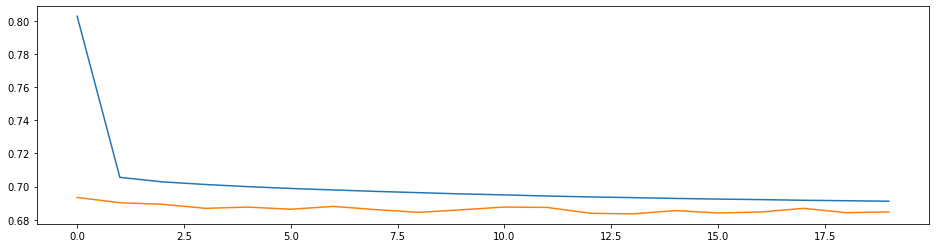

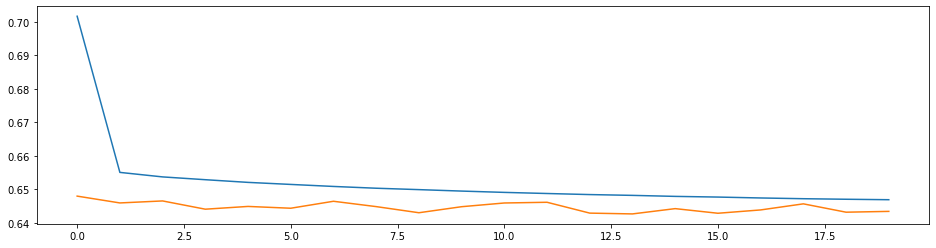

In [78]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(loss_train, label='Train')
ax.plot(loss_valid, label='Validation')
mae_train = history.history['mean_absolute_error']
mae_valid = history.history['val_mean_absolute_error']
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(mae_train, label='Train')
ax.plot(mae_valid, label='Validation')

In [79]:
# Evaluation
test_xp = test_x.reshape(len(test_x),nlat*nlon,3)
test_xp = np.transpose(test_xp, (0, 2, 1))
pred = model.predict(test_xp)
print(np.shape(test_predictands),np.shape(pred))
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

(124280,) (124280, 1)
MSE: 0.63626486


(478, 13, 20) (478, 13, 20)


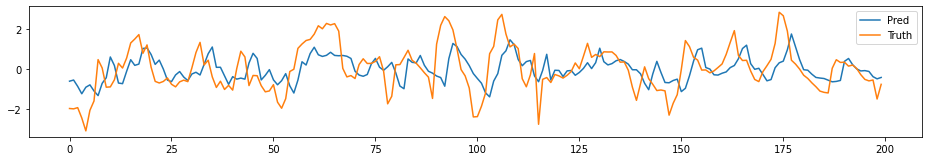

In [80]:
#plot spi time series at random location
pred_3d = pred.reshape(orig_shape_ytest)
test_predictands_3d = test_predictands.reshape(orig_shape_ytest)
print(np.shape(test_predictands_3d),np.shape(pred_3d))
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
lati = np.random.randint(pred_3d.shape[1])
loni = np.random.randint(pred_3d.shape[2])
plt.plot(pred_3d[100:300,lati,loni], label='Pred')
plt.plot(test_predictands_3d[100:300,lati,loni], label='Truth')
plt.legend()

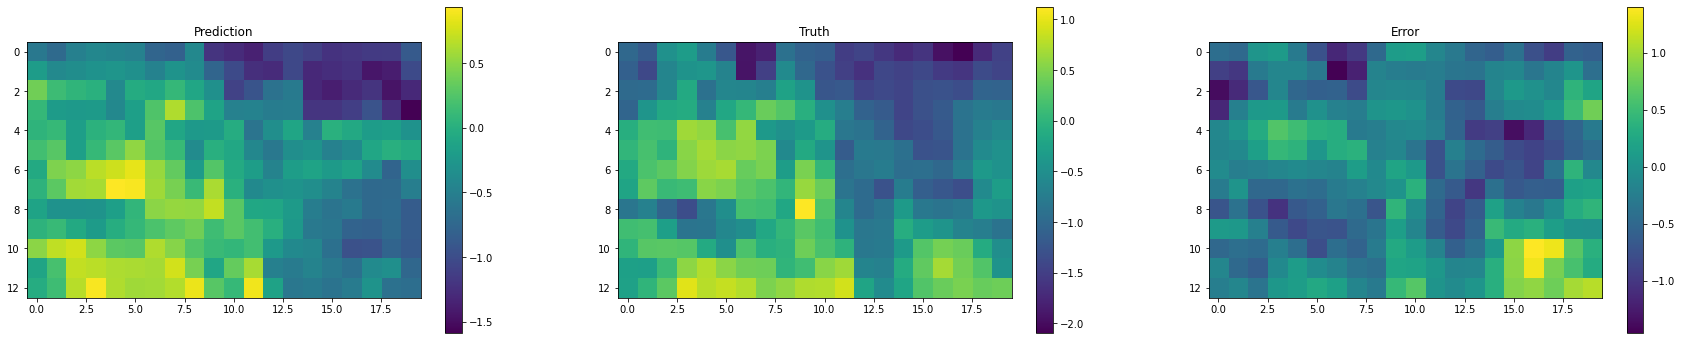

In [81]:
time = np.random.randint(pred_3d.shape[0])
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Prediction')
plt.imshow(pred_3d[time,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Truth')
plt.imshow(test_predictands_3d[time,:,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Error')
plt.imshow(test_predictands_3d[time,:,:]-pred_3d[time,:,:])
plt.colorbar()

In [90]:
inputa = Input(shape=(nlat,nlon,1))
layera = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputa)
#layera = layers.AveragePooling2D()(layera)
#layera = layers.MaxPooling2D(pool_size=(2))(layera)
#layera = layers.Conv2D(8, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(layera)
#layera = layers.AveragePooling2D()(layera)
#layera = layers.MaxPooling2D(pool_size=(2))(layera)
layera = layers.Flatten()(layera)

inputb = Input(shape=(nlat,nlon,1))
layerb = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputb)
#layerb = layers.AveragePooling2D()(layerb)
#layerb = layers.MaxPooling2D(pool_size=(2))(layerb)
#layerb = layers.Conv2D(8, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(layerb)
#layerb = layers.AveragePooling2D()(layerb)
#layerb = layers.MaxPooling2D(pool_size=(2))(layerb)
layerb = layers.Flatten()(layerb)

inputc = Input(shape=(nlat,nlon,1))
layerc = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputc)
#layerc = layers.AveragePooling2D()(layerc)
#layerc = layers.MaxPooling2D(pool_size=(2))(layerc)
#layerc = layers.Conv2D(8, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(layerc)
#layerc = layers.AveragePooling2D()(layerc)
#layerc = layers.MaxPooling2D(pool_size=(2))(layerc)
layerc = layers.Flatten()(layerc)

layer1 = layers.Concatenate()([layera,layerb,layerc])
#layer1 = layers.Reshape((3, 5*9*240), input_shape=(5*9*240*3,))(layer1)
#layer1 = layers.Reshape((3, 1*3*8), input_shape=(1*3*8*3,))(layer1)
layer1 = layers.Reshape((3, 11*18*16), input_shape=(11*18*16*3,))(layer1)
layer1 = layers.LSTM(4, return_sequences=True)(layer1)
#layer1 = layers.Dropout(0.25)(layer1)
layer1 = layers.LSTM(2)(layer1)
output_tensor = layers.Dense(1)(layer1)
model = Model([inputa,inputb,inputc], output_tensor)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 13, 20, 1)    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 13, 20, 1)    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 13, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 11, 18, 16)   160         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [91]:
jj = randint(0,len(train_xt)-2000)  # randomly select 1500 successive months to train because it takes too long to train all the samples
print(jj)
train_xp = train_x[jj:jj+2000,:,:,:,:,:]
train_xp = train_xp.reshape(len(train_xp)*nlat*nlon,nlat,nlon,3)
train_yp = train_yt[jj:jj+2000,:,:]
train_yp = train_yp.reshape(len(train_yp)*nlat*nlon,1)
valid_xp = valid_x.reshape(len(valid_x),nlat,nlon,3)
traina = train_xp[:,:,:,0]
traina = traina[..., np.newaxis]
trainb = train_xp[:,:,:,1]
trainb = trainb[..., np.newaxis]
trainc = train_xp[:,:,:,2]
trainc = trainc[..., np.newaxis]
valida = valid_xp[:,:,:,0]
valida = valida[..., np.newaxis]
validb = valid_xp[:,:,:,1]
validb = validb[..., np.newaxis]
validc = valid_xp[:,:,:,2]
validc = validc[..., np.newaxis]
path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon_cnn_2.h5'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=path_save_weigths,
        monitor='val_loss',
        save_best_only=True,
    )
]
opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=opt,loss='mse',metrics=['mae'])
history = model.fit([traina,trainb,trainc], train_yp, epochs=40, batch_size=256, callbacks=callbacks_list, validation_data=([valida,validb,validc], valid_predictands), verbose=2)
loss_train = history.history['loss']
loss_valid = history.history['val_loss']

220
Train on 520000 samples, validate on 498680 samples
Epoch 1/40
 - 47s - loss: 0.9673 - mean_absolute_error: 0.7791 - val_loss: 0.8767 - val_mean_absolute_error: 0.7391
Epoch 2/40
 - 43s - loss: 0.8245 - mean_absolute_error: 0.7153 - val_loss: 0.7709 - val_mean_absolute_error: 0.6871
Epoch 3/40
 - 43s - loss: 0.7486 - mean_absolute_error: 0.6770 - val_loss: 0.7159 - val_mean_absolute_error: 0.6597
Epoch 4/40
 - 43s - loss: 0.7213 - mean_absolute_error: 0.6631 - val_loss: 0.7022 - val_mean_absolute_error: 0.6528
Epoch 5/40
 - 43s - loss: 0.7127 - mean_absolute_error: 0.6587 - val_loss: 0.6977 - val_mean_absolute_error: 0.6506
Epoch 6/40
 - 43s - loss: 0.7086 - mean_absolute_error: 0.6567 - val_loss: 0.6956 - val_mean_absolute_error: 0.6500
Epoch 7/40
 - 43s - loss: 0.7059 - mean_absolute_error: 0.6554 - val_loss: 0.7021 - val_mean_absolute_error: 0.6536
Epoch 8/40
 - 43s - loss: 0.7040 - mean_absolute_error: 0.6543 - val_loss: 0.6918 - val_mean_absolute_error: 0.6472
Epoch 9/40
 - 43

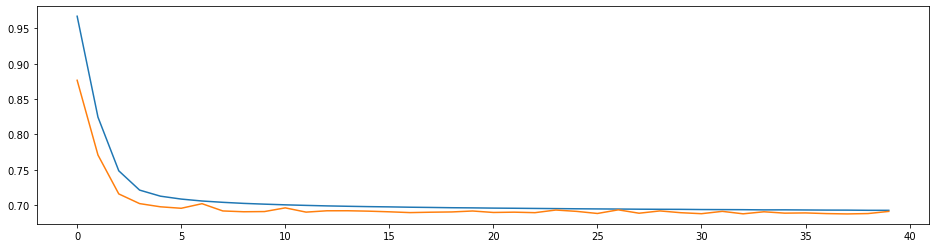

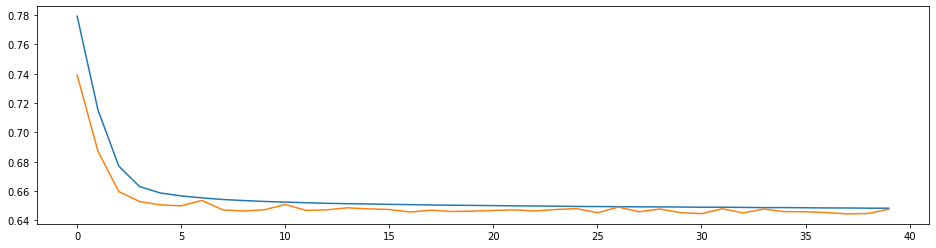

In [92]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(loss_train, label='Train')
ax.plot(loss_valid, label='Validation')
mae_train = history.history['mean_absolute_error']
mae_valid = history.history['val_mean_absolute_error']
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(mae_train, label='Train')
ax.plot(mae_valid, label='Validation')

In [93]:
# Evaluation
test_xp = test_x.reshape(len(test_x),nlat,nlon,3)
testa = test_xp[:,:,:,0]
testa = testa[..., np.newaxis]
testb = test_xp[:,:,:,1]
testb = testb[..., np.newaxis]
testc = test_xp[:,:,:,2]
testc = testc[..., np.newaxis]
pred = model.predict([testa,testb,testc])
print(np.shape(test_predictands),np.shape(pred))
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

(124280,) (124280, 1)
MSE: 0.6381141


In [96]:
test_input = np.load('test_input.npy')
print(test_input.shape)
test_input_regr = test_input.reshape(120*nlat*nlon,3)
print(test_input_regr.shape)

(120, 13, 20, 3)
(31200, 3)


In [98]:
test_output_regr = regr.predict(test_input_regr)
print(test_output_regr.shape)
test_output_regr = test_output_regr.reshape(120,nlat,nlon)
print(test_output_regr.shape)

(31200,)
(120, 13, 20)


In [112]:
from joblib import dump, load

In [113]:
path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon_lstm.h5'
input_tensor = Input(shape=(3,nlon*nlat))
layer1 = layers.LSTM(4,return_sequences=True)(input_tensor)
layer1 = layers.LSTM(2)(layer1)
output_tensor = layers.Dense(1)(layer1)
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=path_save_weigths,
        monitor='val_loss',
        save_best_only=True,
    )
]
model_test = Model(input_tensor, output_tensor)
model_test.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
model_test.load_weights(path_save_weigths)

In [118]:
test_input_lstm = np.ndarray((len(test_input),nlat,nlon,nlat,nlon,3))
for ii in range(nlat):
    for jj in range(nlon):
        test_input_lstm[:,ii,jj,ii,jj,:] = test_input[:,ii,jj,:]
test_input_lstm = test_input_lstm.reshape(120*nlat*nlon,nlat,nlon,3)
test_input_lstm = test_input_lstm.reshape(len(test_input_lstm),nlat*nlon,3)
test_input_lstm = np.transpose(test_input_lstm, (0, 2, 1))
test_output_lstm = model_test.predict(test_input_lstm)
print(test_output_lstm.shape)
test_output_lstm = test_output_lstm.reshape(120,nlat,nlon)
print(test_output_lstm.shape)

(31200, 1)
(120, 13, 20)


In [94]:
path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon_cnn_2.h5'
inputa = Input(shape=(nlat,nlon,1))
layera = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputa)
#layera = layers.AveragePooling2D()(layera)
#layera = layers.MaxPooling2D(pool_size=(2))(layera)
#layera = layers.Conv2D(8, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(layera)
#layera = layers.AveragePooling2D()(layera)
#layera = layers.MaxPooling2D(pool_size=(2))(layera)
layera = layers.Flatten()(layera)

inputb = Input(shape=(nlat,nlon,1))
layerb = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputb)
layerb = layers.Flatten()(layerb)

inputc = Input(shape=(nlat,nlon,1))
layerc = layers.Conv2D(16, kernel_size=(3), activation='relu', kernel_initializer='he_uniform')(inputc)
layerc = layers.Flatten()(layerc)

layer1 = layers.Concatenate()([layera,layerb,layerc])
layer1 = layers.Reshape((3, 11*18*16), input_shape=(11*18*16*3,))(layer1)
layer1 = layers.LSTM(4, return_sequences=True)(layer1)
layer1 = layers.LSTM(2)(layer1)
output_tensor = layers.Dense(1)(layer1)
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=path_save_weigths,
        monitor='val_loss',
        save_best_only=True,
    )
]
opt = keras.optimizers.RMSprop(lr=0.0001)
model_test1 = Model([inputa,inputb,inputc], output_tensor)
model_test1.compile(optimizer=opt,loss='mse',metrics=['mae'])
model_test1.load_weights(path_save_weigths)

In [97]:
test_input_cnn = np.ndarray((len(test_input),nlat,nlon,nlat,nlon,3))
for ii in range(nlat):
    for jj in range(nlon):
        test_input_cnn[:,ii,jj,ii,jj,:] = test_input[:,ii,jj,:]
test_input_cnn = test_input_cnn.reshape(len(test_input)*nlat*nlon,nlat,nlon,3)
testia = test_input_cnn[:,:,:,0]
testia = testia[..., np.newaxis]
testib = test_input_cnn[:,:,:,1]
testib = testib[..., np.newaxis]
testic = test_input_cnn[:,:,:,2]
testic = testic[..., np.newaxis]
test_output_cnn = model_test1.predict([testia,testib,testic])
print(test_output_cnn.shape)
test_output_cnn = test_output_cnn.reshape(120,nlat,nlon)
print(test_output_cnn.shape)

(31200, 1)
(120, 13, 20)


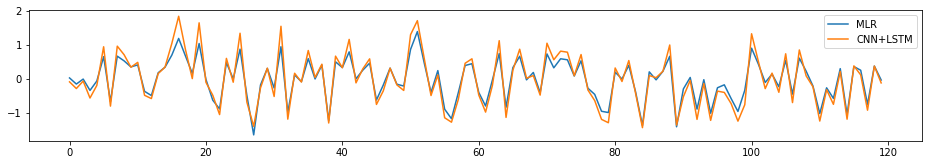

In [99]:
#plot spi time series at random location
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
lati = np.random.randint(nlat)
loni = np.random.randint(nlon)
plt.plot(test_output_regr[:,lati,loni], label='MLR')
#plt.plot(test_output_lstm[:,lati,loni], label='LSTM')
plt.plot(test_output_cnn[:,lati,loni], label='CNN+LSTM')
plt.legend()

In [100]:
np.save('test_submission.npy',test_output_cnn)